<a href="https://colab.research.google.com/github/seliyos/Predicting-Real-Estate-Prices/blob/master/Final_CS4463.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ============================================================
# 0) Imports
# ============================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline


In [3]:
# ============================================================
# 1) Load data
# ============================================================

possible_paths = ["train.csv", "./train.csv", "../data/train.csv", "data/train.csv"]
train_path = None
for p in possible_paths:
    if os.path.exists(p):
        train_path = p
        break

if train_path is None:
    raise FileNotFoundError("Could not find train.csv. Upload it in Colab Files (left panel) and try again.")

train_df = pd.read_csv(train_path)
print("Loaded:", train_path)
print(f"Dataset shape: {train_df.shape}")
train_df.head()


Loaded: train.csv
Dataset shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



Columns: ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities'] ...

Target summary (SalePrice):
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


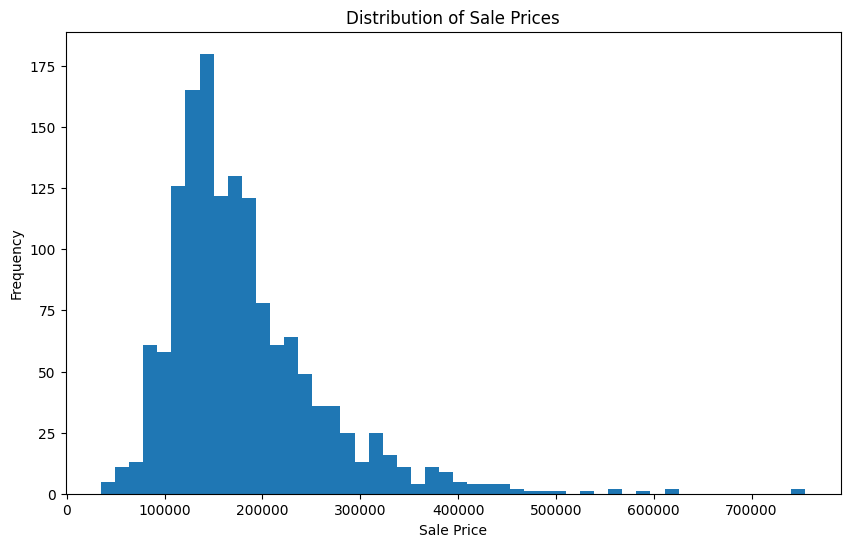


Top 15 columns with most missing values:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
dtype: int64


In [4]:
# ============================================================
# 2) Quick EDA
# ============================================================

print("\nColumns:", train_df.columns.tolist()[:10], "...")
print("\nTarget summary (SalePrice):")
print(train_df["SalePrice"].describe())

plt.figure(figsize=(10, 6))
plt.hist(train_df["SalePrice"], bins=50)
plt.xlabel("Sale Price")
plt.ylabel("Frequency")
plt.title("Distribution of Sale Prices")
plt.show()

# Basic missingness check (top 15 columns with most missing)
missing_counts = train_df.isna().sum().sort_values(ascending=False)
print("\nTop 15 columns with most missing values:")
print(missing_counts.head(15))


In [5]:
# ============================================================
# 3) Define features (X) and target (y)
# ============================================================

# Drop Id
if "Id" in train_df.columns:
    train_df = train_df.drop(columns=["Id"])

y = train_df["SalePrice"]
X = train_df.drop(columns=["SalePrice"])

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1460, 79)
y shape: (1460,)


In [6]:
# ============================================================
# 4) Train/Test split (reproducible)
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 1168 Test size: 292


In [7]:
# ============================================================
# 5) Preprocessing pipeline (handles missing + categorical encoding)
# ============================================================

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))


Numeric features: 36
Categorical features: 43


In [9]:
# ============================================================
# Helper: metrics function
# ============================================================

def regression_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2


In [11]:
# ============================================================
# 6) Baseline model (REQUIRED): Linear Regression
# ============================================================

# Build baseline pipeline
baseline_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

# Train model
baseline_model.fit(X_train, y_train)

# Predict on test set
baseline_pred = baseline_model.predict(X_test)

# ---- Metrics (fixed for sklearn version) ----
mse = mean_squared_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mse)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

# Print results
print("Baseline (Linear Regression) metrics on TEST:")
print("RMSE:", round(baseline_rmse, 2))
print("MAE :", round(baseline_mae, 2))
print("R^2 :", round(baseline_r2, 4))


Baseline (Linear Regression) metrics on TEST:
RMSE: 31294.99
MAE : 20466.13
R^2 : 0.8723


In [13]:
# ============================================================
# 7) Oracle model
# ============================================================

oracle_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        n_jobs=-1
    ))
])

# Train oracle model
oracle_model.fit(X_train, y_train)

# Predict on TRAIN data
oracle_pred_train = oracle_model.predict(X_train)

# ---- Metrics (fixed, no squared argument) ----
oracle_mse = mean_squared_error(y_train, oracle_pred_train)
oracle_rmse = np.sqrt(oracle_mse)
oracle_mae = mean_absolute_error(y_train, oracle_pred_train)
oracle_r2 = r2_score(y_train, oracle_pred_train)

# Print results
print("Oracle (Cheating) metrics on TRAIN (upper bound reference):")
print("RMSE:", round(oracle_rmse, 2))
print("MAE :", round(oracle_mae, 2))
print("R^2 :", round(oracle_r2, 4))


Oracle (Cheating) metrics on TRAIN (upper bound reference):
RMSE: 11286.5
MAE : 6507.87
R^2 : 0.9786


In [14]:
# ============================================================
# 8) Advanced model (main method): Random Forest Regressor
# ============================================================

rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        n_jobs=-1
    ))
])

# Train model
rf_model.fit(X_train, y_train)

# Predict on TEST data
rf_pred = rf_model.predict(X_test)

# ---- Metrics (safe version) ----
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("Advanced Model (Random Forest) metrics on TEST:")
print("RMSE:", round(rf_rmse, 2))
print("MAE :", round(rf_mae, 2))
print("R^2 :", round(rf_r2, 4))


Advanced Model (Random Forest) metrics on TEST:
RMSE: 28595.03
MAE : 17429.17
R^2 : 0.8934


In [15]:
# ============================================================
# 9) Model comparison table
# ============================================================

results = pd.DataFrame([
    {
        "Model": "Baseline: Linear Regression (TEST)",
        "RMSE": baseline_rmse,
        "MAE": baseline_mae,
        "R2": baseline_r2
    },
    {
        "Model": "Oracle: Random Forest (TRAIN, cheating)",
        "RMSE": oracle_rmse,
        "MAE": oracle_mae,
        "R2": oracle_r2
    },
    {
        "Model": "Advanced: Random Forest (TEST)",
        "RMSE": rf_rmse,
        "MAE": rf_mae,
        "R2": rf_r2
    }
])

results


,Model,RMSE,MAE,R2
0,Baseline: Linear Regression (TEST),31294.990974,20466.133696,0.872316
1,"Oracle: Random Forest (TRAIN, cheating)",11286.497443,6507.874493,0.978643
2,Advanced: Random Forest (TEST),28595.032227,17429.173719,0.893398


In [24]:
# ============================================================
# 10) VISUALIZATION & ERROR ANALYSIS
# ============================================================

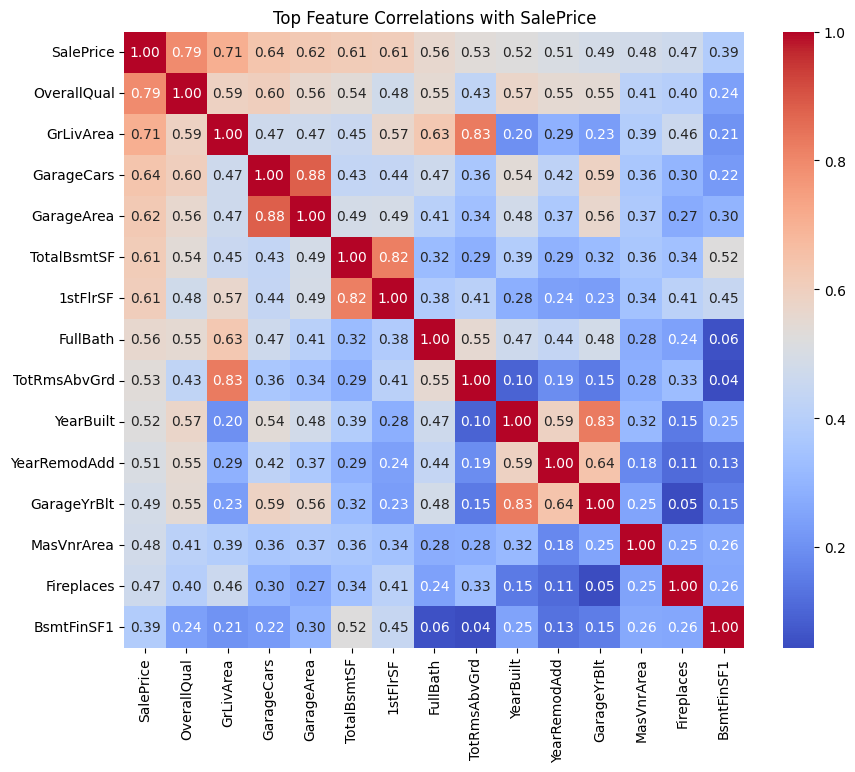

In [25]:
# 10.1 Feature Correlation with SalePrice

corr = train_df.corr(numeric_only=True)

top_corr = corr["SalePrice"].abs().sort_values(ascending=False).head(15).index

plt.figure(figsize=(10,8))
sns.heatmap(corr.loc[top_corr, top_corr], annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Top Feature Correlations with SalePrice")
plt.show()


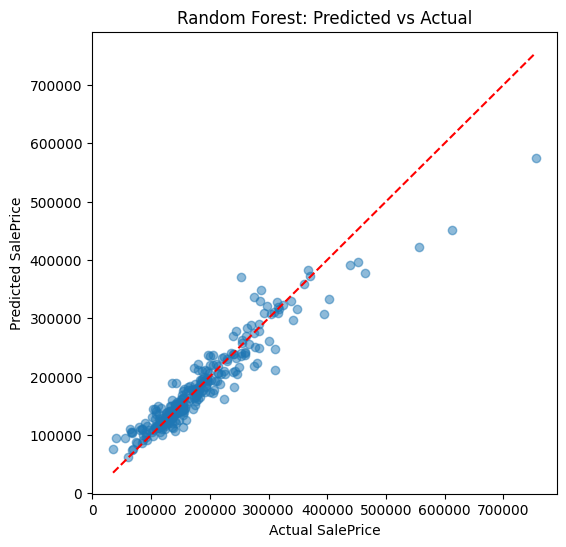

In [26]:
# 10.2 Predicted vs Actual (Random Forest)

plt.figure(figsize=(6,6))
plt.scatter(y_test, rf_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Random Forest: Predicted vs Actual")
plt.show()


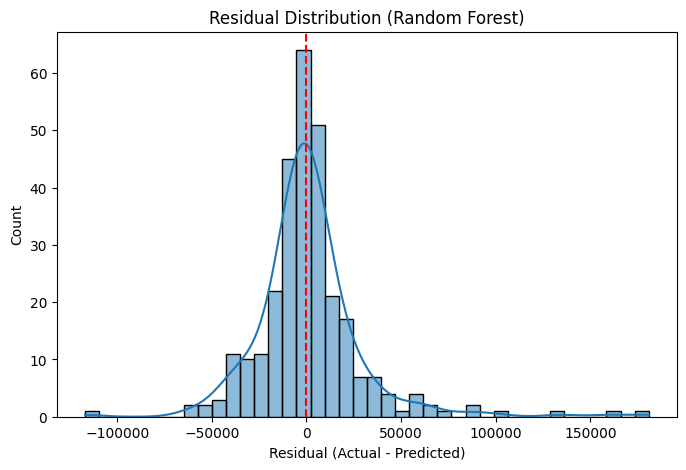

In [27]:
# 10.3 Residual Distribution (Random Forest)

residuals = y_test - rf_pred

plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=40, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Residual Distribution (Random Forest)")
plt.show()


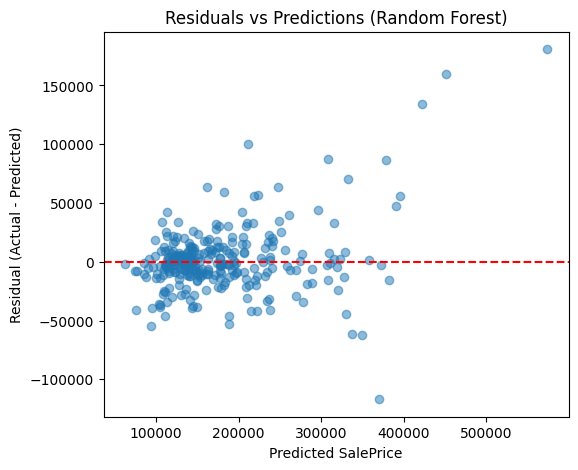

In [28]:
# 10.4 Residuals vs Predictions (Random Forest)

plt.figure(figsize=(6,5))
plt.scatter(rf_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predictions (Random Forest)")
plt.show()
